In [136]:
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
features = pd.read_pickle("sel+demo_features2.pkl")
target = pd.read_pickle("target.pkl")
print(features.shape, target.shape)
print(target[target['MCQ220'] == 1].shape)

(49509, 57) (49509, 1)
(4578, 1)


In [173]:
features = pd.read_pickle("selected_features.pkl")

In [182]:
dataset_features = features.values
dataset_targets=target.values.flatten()

In [183]:
# train/test separation
perm = np.random.permutation(dataset_targets.shape[0])
dataset_features = dataset_features[perm]
dataset_targets = dataset_targets[perm]

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]

### First attempt

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

features_trn, targets_trn = get_batch(n_size=8000, phase='train')
features_tst, targets_tst = get_batch(n_size=900, phase='test')

clf = RandomForestClassifier(n_estimators=750)
clf.fit(features_trn, targets_trn)
preds_tst_RFC1 = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)

clf = SVC(gamma='auto')
clf.fit(features_trn, targets_trn)
preds_tst_SVC1 = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_SVC', accu)

clf = LogisticRegression(solver='lbfgs', max_iter=2000)
clf.fit(features_trn, targets_trn)
preds_tst_LR1 = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_LR', accu)



accu_tst_RFC 0.49333333333333335
accu_tst_SVC 0.49333333333333335
accu_tst_LR 0.49333333333333335


In [178]:
print(classification_report(targets_tst, preds_tst_RFC1.flatten()))
print(classification_report(targets_tst, preds_tst_SVC1.flatten()))
print(classification_report(targets_tst, preds_tst_LR1.flatten()))

              precision    recall  f1-score   support

         0.0       0.59      0.77      0.67       450
         1.0       0.67      0.46      0.55       450

    accuracy                           0.62       900
   macro avg       0.63      0.62      0.61       900
weighted avg       0.63      0.62      0.61       900

              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65       450
         1.0       0.63      0.42      0.50       450

    accuracy                           0.59       900
   macro avg       0.60      0.59      0.58       900
weighted avg       0.60      0.59      0.58       900

              precision    recall  f1-score   support

         0.0       0.58      0.70      0.63       450
         1.0       0.62      0.49      0.55       450

    accuracy                           0.59       900
   macro avg       0.60      0.59      0.59       900
weighted avg       0.60      0.59      0.59       900



In [152]:
features_trn, targets_trn = get_batch(n_size=15000, phase='train')
features_tst, targets_tst = get_batch(n_size=3000, phase='test')

acc = []
ns = []

for n in [10, 25, 50, 100, 250, 500, 750, 1000, 1250, 1500]:
    accs = []
    for m in range(10):
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(features_trn, targets_trn)
        preds_tst = clf.predict(features_tst)
        accu = np.mean(preds_tst==targets_tst)
        accs.append(accu)
    ns.append(n)
    acc.append(np.mean(accs))

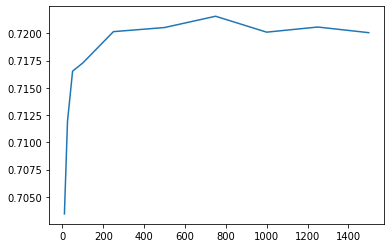

In [153]:
sns.lineplot(ns, acc)

### Now trying on larger sets

In [111]:
features_trn, targets_trn = get_batch(n_size=15000, phase='train')
features_tst, targets_tst = get_batch(n_size=3000, phase='test')

clf = RandomForestClassifier(n_estimators=500)
clf.fit(features_trn, targets_trn)
preds_tst_RCL = clf.predict(features_tst)
accu = np.mean(preds_tst_RCL==targets_tst)
print('accu_tst_RFC', accu)

clf = SVC(gamma='auto')
clf.fit(features_trn, targets_trn)
preds_tst_SVC = clf.predict(features_tst)
accu = np.mean(preds_tst_SVC==targets_tst)
print('accu_tst_SVC', accu)

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(features_trn, targets_trn)
preds_tst_LR = clf.predict(features_tst)
accu = np.mean(preds_tst_LR==targets_tst)
print('accu_tst_LR', accu)

accu_tst_RFC 0.7065514103730665
accu_tst_SVC 0.6901728844404004
accu_tst_LR 0.697452229299363


ValueError: Found input variables with inconsistent numbers of samples: [900, 400]

### Try a neural network

In [106]:
from keras import Sequential
from keras.layers import Dense

## using original size of train/test
features_trn, targets_trn = get_batch(n_size=15000, phase='train')
features_tst, targets_tst = get_batch(n_size=3000, phase='test')

In [112]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal', input_dim=features_trn.shape[1]))
#Second  Hidden Layer
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
classifier.fit(features_trn,targets_trn, batch_size=5, epochs=25)

#predict on the test set
preds_tst=classifier.predict(features_tst)
preds_tst_bin =(preds_tst>0.5)

Epoch 1/25
10691/10691 [==============================] - 4s 377us/step - loss: 0.5907 - acc: 0.7012
Epoch 2/25
10691/10691 [==============================] - 4s 346us/step - loss: 0.5768 - acc: 0.7064
Epoch 3/25
10691/10691 [==============================] - 4s 395us/step - loss: 0.5751 - acc: 0.7114
Epoch 4/25
10691/10691 [==============================] - 4s 383us/step - loss: 0.5740 - acc: 0.7129
Epoch 5/25
10691/10691 [==============================] - 4s 387us/step - loss: 0.5728 - acc: 0.7127
Epoch 6/25
10691/10691 [==============================] - 4s 385us/step - loss: 0.5728 - acc: 0.7083
Epoch 7/25
10691/10691 [==============================] - 4s 391us/step - loss: 0.5718 - acc: 0.7148
Epoch 8/25
10691/10691 [==============================] - 4s 390us/step - loss: 0.5728 - acc: 0.7121
Epoch 9/25
10691/10691 [==============================] - 4s 389us/step - loss: 0.5704 - acc: 0.7140
Epoch 10/25
10691/10691 [==============================] - 4s 391us/step - loss: 0.5705 - a

In [113]:
#measure accuracy
accu = np.mean(preds_tst_bin.flatten()==targets_tst)
print('accu_tst_NN', accu)

accu_tst_NN 0.6933575978161965


In [70]:
preds_tst

array([[0.08127615],
       [0.52853453],
       [0.1401828 ],
       ...,
       [0.15197423],
       [0.22212602],
       [0.0986653 ]], dtype=float32)

In [71]:
targets_tst

array([0., 1., 0., ..., 0., 1., 0.])

,MCQ220
DMDHRAGE,0.256813
DMQMILIT,0.114839
RIDAGEYR,0.284032
DR1HELPD,0.000660
DR1TKCAL,-0.054950
DR1TM161,-0.044415
DR1TS100,-0.002619
DR1TS140,-0.017791
DR1TSUGR,-0.026063
DR2HELPD,-0.034258


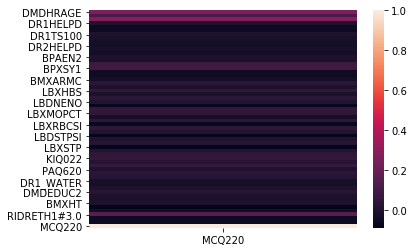

In [72]:
import datawig

df = pd.concat([features, target], axis = 1)
df = df.reset_index().drop(columns = ["SEQN"])

df_train, df_test = datawig.utils.random_split(df, split_ratios=[0.8, 0.2])

sns.heatmap(df.corr()[['MCQ220']])
df.corr()[['MCQ220']]

In [75]:
#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    #input_columns=list(features.columns), # column(s) containing information about the column we want to impute
    input_columns = ['RIDAGEYR', 'DMQMILIT', 'DMDHRAGE'],
    output_column='MCQ220', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df_train)

#Impute missing values and return original dataframe with predictions
#predictions, metrics = imputer.transform_and_compute_metrics(df_test)
#metrics

predictions = imputer.predict(df_test)

/Users/Artem/anaconda/envs/py3tensor/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/Users/Artem/anaconda/envs/py3tensor/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/Artem/anaconda/envs/py3tensor/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downc

In [90]:
data_encoder_cols = [datawig.NumericalEncoder('DMDHRAGE'), 
                     datawig.NumericalEncoder('RIDAGEYR'), 
                     datawig.NumericalEncoder('DR1TKCAL'), 
                     datawig.NumericalEncoder('DR1TM161'), 
                     datawig.NumericalEncoder('DR1TS100'), 
                     datawig.NumericalEncoder('DR1TS140'), 
                     datawig.NumericalEncoder('DR1TSUGR'), 
                     datawig.NumericalEncoder('DR2TNIAC'), 
                     datawig.NumericalEncoder('DR2TPROT'), 
                     datawig.NumericalEncoder('DR1_WATER'), 
                     datawig.NumericalEncoder('BPXSY2'), 
                     datawig.NumericalEncoder('BPXSY1'), 
                     datawig.NumericalEncoder('BPXDI2'),
                     datawig.NumericalEncoder('BPXDI1'),
                     datawig.NumericalEncoder('BMXARMC'),
                     datawig.NumericalEncoder('BMXARML'),
                     datawig.NumericalEncoder('BMXHT'),
                     datawig.NumericalEncoder('LBXHBS'),
                     datawig.NumericalEncoder('LBDLYMNO'),
                     datawig.NumericalEncoder('LBDMONO'),
                     datawig.NumericalEncoder('LBDNENO'),
                     datawig.NumericalEncoder('LBXLYPCT'),
                     datawig.NumericalEncoder('LBXMCHSI'),
                     datawig.NumericalEncoder('LBXMOPCT'),
                     datawig.NumericalEncoder('LBXMPSI'),
                     datawig.NumericalEncoder('LBXNEPCT'),
                     datawig.NumericalEncoder('LBXRBCSI'),
                     datawig.NumericalEncoder('LBXRDW'),
                     datawig.NumericalEncoder('LBDSCASI'),
                     datawig.NumericalEncoder('LBDSTPSI'),
                     datawig.NumericalEncoder('LBXSCA'),
                     datawig.NumericalEncoder('LBXSNASI'),
                     datawig.NumericalEncoder('LBXSTP'),
                     datawig.NumericalEncoder('HSD010'),
                     datawig.NumericalEncoder('BMXBMI'),
                     datawig.NumericalEncoder('BMXWT'),
                     datawig.NumericalEncoder('BMXHT'),
                     datawig.CategoricalEncoder('DMQMILIT'),
                     datawig.CategoricalEncoder('DR1HELPD'),
                     datawig.CategoricalEncoder('DR2HELPD'),
                     datawig.CategoricalEncoder('BPAEN2'),
                     datawig.CategoricalEncoder('BPXPTY'),
                     datawig.CategoricalEncoder('BPQ040A'),
                     datawig.CategoricalEncoder('KIQ022'),
                     datawig.CategoricalEncoder('MCQ010'),
                     datawig.CategoricalEncoder('MCQ160N'),
                     datawig.CategoricalEncoder('PAQ620'),
                     datawig.CategoricalEncoder('PFQ059'),
                     datawig.CategoricalEncoder('HUQ090'),
                     datawig.CategoricalEncoder('SXQ'),
                     datawig.CategoricalEncoder('RIDRETH1#1.0'),
                     datawig.CategoricalEncoder('RIDRETH1#2.0'),
                     datawig.CategoricalEncoder('RIDRETH1#3.0'),
                     datawig.CategoricalEncoder('RIDRETH1#4.0'),
                     datawig.CategoricalEncoder('RIDRETH1#5.0')
                    ]


data_featurizer_cols = [datawig.NumericalFeaturizer('DMDHRAGE'), 
                     datawig.NumericalFeaturizer('RIDAGEYR'), 
                     datawig.NumericalFeaturizer('DR1TKCAL'), 
                     datawig.NumericalFeaturizer('DR1TM161'), 
                     datawig.NumericalFeaturizer('DR1TS100'), 
                     datawig.NumericalFeaturizer('DR1TS140'), 
                     datawig.NumericalFeaturizer('DR1TSUGR'), 
                     datawig.NumericalFeaturizer('DR2TNIAC'), 
                     datawig.NumericalFeaturizer('DR2TPROT'), 
                     datawig.NumericalFeaturizer('DR1_WATER'), 
                     datawig.NumericalFeaturizer('BPXSY2'), 
                     datawig.NumericalFeaturizer('BPXSY1'), 
                     datawig.NumericalFeaturizer('BPXDI2'),
                     datawig.NumericalFeaturizer('BPXDI1'),
                     datawig.NumericalFeaturizer('BMXARMC'),
                     datawig.NumericalFeaturizer('BMXARML'),
                     datawig.NumericalFeaturizer('BMXHT'),
                     datawig.NumericalFeaturizer('LBXHBS'),
                     datawig.NumericalFeaturizer('LBDLYMNO'),
                     datawig.NumericalFeaturizer('LBDMONO'),
                     datawig.NumericalFeaturizer('LBDNENO'),
                     datawig.NumericalFeaturizer('LBXLYPCT'),
                     datawig.NumericalFeaturizer('LBXMCHSI'),
                     datawig.NumericalFeaturizer('LBXMOPCT'),
                     datawig.NumericalFeaturizer('LBXMPSI'),
                     datawig.NumericalFeaturizer('LBXNEPCT'),
                     datawig.NumericalFeaturizer('LBXRBCSI'),
                     datawig.NumericalFeaturizer('LBXRDW'),
                     datawig.NumericalFeaturizer('LBDSCASI'),
                     datawig.NumericalFeaturizer('LBDSTPSI'),
                     datawig.NumericalFeaturizer('LBXSCA'),
                     datawig.NumericalFeaturizer('LBXSNASI'),
                     datawig.NumericalFeaturizer('LBXSTP'),
                     datawig.NumericalFeaturizer('HSD010'),
                     datawig.NumericalFeaturizer('BMXBMI'),
                     datawig.NumericalFeaturizer('BMXWT'),
                     datawig.NumericalFeaturizer('BMXHT'),
                     datawig.EmbeddingFeaturizer('DMQMILIT'),
                     datawig.EmbeddingFeaturizer('DR1HELPD'),
                     datawig.EmbeddingFeaturizer('DR2HELPD'),
                     datawig.EmbeddingFeaturizer('BPAEN2'),
                     datawig.EmbeddingFeaturizer('BPXPTY'),
                     datawig.EmbeddingFeaturizer('BPQ040A'),
                     datawig.EmbeddingFeaturizer('KIQ022'),
                     datawig.EmbeddingFeaturizer('MCQ010'),
                     datawig.EmbeddingFeaturizer('MCQ160N'),
                     datawig.EmbeddingFeaturizer('PAQ620'),
                     datawig.EmbeddingFeaturizer('PFQ059'),
                     datawig.EmbeddingFeaturizer('HUQ090'),
                     datawig.EmbeddingFeaturizer('SXQ'),
                     datawig.EmbeddingFeaturizer('RIDRETH1#1.0'),
                     datawig.EmbeddingFeaturizer('RIDRETH1#2.0'),
                     datawig.EmbeddingFeaturizer('RIDRETH1#3.0'),
                     datawig.EmbeddingFeaturizer('RIDRETH1#4.0'),
                     datawig.EmbeddingFeaturizer('RIDRETH1#5.0')
                    ]
label_encoder_cols = [datawig.CategoricalEncoder('MCQ220')]

imputer = datawig.Imputer(
    data_featurizers=data_featurizer_cols,
    label_encoders=label_encoder_cols,
    data_encoders=data_encoder_cols,
    output_path='imputer_model'
)

imputer.fit(train_df=df_train)
predictions = imputer.predict(df_test)

ValueError: Columns must be same length as key

In [92]:
print(len(data_encoder_cols),len(data_featurizer_cols))

55 55


In [88]:
predictions['MCQ220_imputed'].describe()

count    9901.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: MCQ220_imputed, dtype: float64

In [85]:
df_train.columns

Index(['DMDHRAGE', 'DMQMILIT', 'RIDAGEYR', 'DR1HELPD', 'DR1TKCAL', 'DR1TM161',
       'DR1TS100', 'DR1TS140', 'DR1TSUGR', 'DR2HELPD', 'DR2TNIAC', 'DR2TPROT',
       'BPAEN2', 'BPXPTY', 'BPXSY2', 'BPXSY1', 'BPXDI2', 'BPXDI1', 'BMXARMC',
       'BMXARML', 'BMXHT', 'LBXHBS', 'LBDLYMNO', 'LBDMONO', 'LBDNENO',
       'LBXLYPCT', 'LBXMCHSI', 'LBXMOPCT', 'LBXMPSI', 'LBXNEPCT', 'LBXRBCSI',
       'LBXRDW', 'LBDSCASI', 'LBDSTPSI', 'LBXSCA', 'LBXSNASI', 'LBXSTP',
       'BPQ040A', 'HSD010', 'KIQ022', 'MCQ010', 'MCQ160N', 'PAQ620', 'PFQ059',
       'HUQ090', 'DR1_WATER', 'SXQ', 'RIAGENDR', 'DMDEDUC2', 'BMXBMI', 'BMXWT',
       'BMXHT', 'RIDRETH1#1.0', 'RIDRETH1#2.0', 'RIDRETH1#3.0', 'RIDRETH1#4.0',
       'RIDRETH1#5.0', 'MCQ220'],
      dtype='object')

### Build Simple Voter based on 4 high performing prediction algorithms

In [114]:
print(preds_tst_RCL.flatten().shape)
print(preds_tst_SVC.flatten().shape)
print(preds_tst_LR.flatten().shape)
print(preds_tst_bin.flatten().shape)

(2198,)
(2198,)
(2198,)
(2198,)


In [126]:
pred = 0.25*(1.001*preds_tst_RCL.flatten() + preds_tst_SVC.flatten() + preds_tst_LR.flatten() + preds_tst_bin.flatten())
pred_bin = pred>=0.5
accu = np.mean(pred_bin==targets_tst)
print('accu_tst_ensemble', accu)
print(classification_report(targets_tst, pred_bin))

accu_tst_ensemble 0.7015468607825296


In [127]:
from sklearn.metrics import classification_report

print(classification_report(targets_tst, pred_bin))
print(classification_report(targets_tst, preds_tst_RCL.flatten()))
print(classification_report(targets_tst, preds_tst_SVC.flatten()))
print(classification_report(targets_tst, preds_tst_LR.flatten()))
print(classification_report(targets_tst, preds_tst_bin.flatten()))


              precision    recall  f1-score   support

         0.0       0.72      0.94      0.81      1500
         1.0       0.59      0.20      0.30       698

    accuracy                           0.70      2198
   macro avg       0.65      0.57      0.55      2198
weighted avg       0.68      0.70      0.65      2198

              precision    recall  f1-score   support

         0.0       0.72      0.94      0.81      1500
         1.0       0.62      0.20      0.30       698

    accuracy                           0.71      2198
   macro avg       0.67      0.57      0.56      2198
weighted avg       0.69      0.71      0.65      2198

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.81      1500
         1.0       0.55      0.14      0.22       698

    accuracy                           0.69      2198
   macro avg       0.63      0.54      0.51      2198
weighted avg       0.65      0.69      0.62      2198

              preci

In [189]:
features_trn2, targets_trn2 = get_batch(n_size=8000, phase='train')
features_tst2, targets_tst2 = get_batch(n_size=2000, phase='test')


clf = RandomForestClassifier(n_estimators=750)
clf.fit(features_trn2, targets_trn2)
preds_tst_RCL = clf.predict(features_tst2)
accu = np.mean(preds_tst_RCL==targets_tst2)
print('accu_tst_RFC', accu)

clf = SVC(gamma='auto')
clf.fit(features_trn2, targets_trn2)
preds_tst_SVC = clf.predict(features_tst2)
accu = np.mean(preds_tst_SVC==targets_tst2)
print('accu_tst_SVC', accu)

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(features_trn2, targets_trn2)
preds_tst_LR = clf.predict(features_tst2)
accu = np.mean(preds_tst_LR==targets_tst2)
print('accu_tst_LR', accu)


print(classification_report(targets_tst2, preds_tst_RCL.flatten()))
print(classification_report(targets_tst2, preds_tst_SVC.flatten()))
print(classification_report(targets_tst2, preds_tst_LR.flatten()))

accu_tst_RFC 0.6329261198371146
accu_tst_SVC 0.6352530541012217
accu_tst_LR 0.6311809191390343
              precision    recall  f1-score   support

         0.0       0.66      0.77      0.71      1000
         1.0       0.58      0.44      0.50       719

    accuracy                           0.63      1719
   macro avg       0.62      0.61      0.61      1719
weighted avg       0.63      0.63      0.62      1719

              precision    recall  f1-score   support

         0.0       0.66      0.78      0.71      1000
         1.0       0.59      0.44      0.50       719

    accuracy                           0.64      1719
   macro avg       0.62      0.61      0.61      1719
weighted avg       0.63      0.64      0.62      1719

              precision    recall  f1-score   support

         0.0       0.67      0.73      0.70      1000
         1.0       0.57      0.50      0.53       719

    accuracy                           0.63      1719
   macro avg       0.62      0.61

In [190]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal', input_dim=features_trn2.shape[1]))
#Second  Hidden Layer
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
classifier.fit(features_trn2,targets_trn2, batch_size=5, epochs=20)

#predict on the test set
preds_tst=classifier.predict(features_tst2)
preds_tst_bin =(preds_tst>0.5)

Epoch 1/20
7206/7206 [==============================] - 4s 589us/step - loss: 0.6683 - acc: 0.5887
Epoch 2/20
7206/7206 [==============================] - 3s 414us/step - loss: 0.6446 - acc: 0.6343
Epoch 3/20
7206/7206 [==============================] - 3s 407us/step - loss: 0.6407 - acc: 0.6400
Epoch 4/20
7206/7206 [==============================] - 3s 352us/step - loss: 0.6385 - acc: 0.6474
Epoch 5/20
7206/7206 [==============================] - 3s 368us/step - loss: 0.6367 - acc: 0.6493
Epoch 6/20
7206/7206 [==============================] - 3s 433us/step - loss: 0.6355 - acc: 0.6485
Epoch 7/20
7206/7206 [==============================] - 3s 392us/step - loss: 0.6341 - acc: 0.6461
Epoch 8/20
7206/7206 [==============================] - 3s 414us/step - loss: 0.6339 - acc: 0.6492
Epoch 9/20
7206/7206 [==============================] - 3s 363us/step - loss: 0.6323 - acc: 0.6514
Epoch 10/20
7206/7206 [==============================] - 3s 374us/step - loss: 0.6321 - acc: 0.6493
Epoch 11/

In [160]:
#measure accuracy
accu = np.mean(preds_tst_bin.flatten()==targets_tst2)
print('accu_tst_NN', accu)
print(classification_report(targets_tst2, preds_tst_bin.flatten()))

accu_tst_NN 0.6733333333333333
              precision    recall  f1-score   support

         0.0       0.63      0.86      0.72       450
         1.0       0.77      0.49      0.60       450

    accuracy                           0.67       900
   macro avg       0.70      0.67      0.66       900
weighted avg       0.70      0.67      0.66       900



In [191]:
pred = 0.25*(preds_tst_RCL.flatten() + preds_tst_SVC.flatten() + preds_tst_LR.flatten() + 1.01*preds_tst_bin.flatten())
pred_bin = pred>=0.5
accu = np.mean(pred_bin==targets_tst2)
print('accu_tst_ensemble', accu)
print(classification_report(targets_tst2, pred_bin))

accu_tst_ensemble 0.6399069226294357
              precision    recall  f1-score   support

         0.0       0.67      0.75      0.71      1000
         1.0       0.58      0.49      0.53       719

    accuracy                           0.64      1719
   macro avg       0.63      0.62      0.62      1719
weighted avg       0.63      0.64      0.63      1719



In [187]:
#features_trn3, targets_trn3 = get_batch(n_size=15000, phase='train')
#features_tst3, targets_tst3 = get_batch(n_size=3750, phase='test')


clf = RandomForestClassifier(n_estimators=750)
clf.fit(features_trn3, targets_trn3)
preds_tst_RCL = clf.predict(features_tst3)
accu = np.mean(preds_tst_RCL==targets_tst3)
print('accu_tst_RFC', accu)

clf = SVC(gamma='auto')
clf.fit(features_trn3, targets_trn3)
preds_tst_SVC = clf.predict(features_tst3)
accu = np.mean(preds_tst_SVC==targets_tst3)
print('accu_tst_SVC', accu)

clf = LogisticRegression(solver='lbfgs', max_iter=2000)
clf.fit(features_trn3, targets_trn3)
preds_tst_LR = clf.predict(features_tst3)
accu = np.mean(preds_tst_LR==targets_tst3)
print('accu_tst_LR', accu)


print(classification_report(targets_tst3, preds_tst_RCL.flatten()))
print(classification_report(targets_tst3, preds_tst_SVC.flatten()))
print(classification_report(targets_tst3, preds_tst_LR.flatten()))

accu_tst_RFC 0.7374710871241326
accu_tst_SVC 0.738242097147263
accu_tst_LR 0.7239784117193524
              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84      1875
         1.0       0.59      0.17      0.27       719

    accuracy                           0.74      2594
   macro avg       0.67      0.56      0.55      2594
weighted avg       0.71      0.74      0.68      2594

              precision    recall  f1-score   support

         0.0       0.75      0.97      0.84      1875
         1.0       0.62      0.15      0.24       719

    accuracy                           0.74      2594
   macro avg       0.68      0.56      0.54      2594
weighted avg       0.71      0.74      0.67      2594

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83      1875
         1.0       0.51      0.16      0.25       719

    accuracy                           0.72      2594
   macro avg       0.63      0.55 

In [184]:
features_trn3, targets_trn3 = get_batch(n_size=15000, phase='train')
features_tst3, targets_tst3 = get_batch(n_size=3750, phase='test')

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal', input_dim=features_trn2.shape[1]))
#Second  Hidden Layer
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
classifier.fit(features_trn3,targets_trn3, batch_size=5, epochs=20)

#predict on the test set
preds_tst=classifier.predict(features_tst3)
preds_tst_bin =(preds_tst>0.5)

#measure accuracy
accu = np.mean(preds_tst_bin.flatten()==targets_tst3)
print('accu_tst_NN', accu)
print(classification_report(targets_tst3, preds_tst_bin.flatten()))

Epoch 1/20
10706/10706 [==============================] - 6s 583us/step - loss: 0.5938 - acc: 0.7005
Epoch 2/20
10706/10706 [==============================] - 4s 381us/step - loss: 0.5775 - acc: 0.7005
Epoch 3/20
10706/10706 [==============================] - 4s 393us/step - loss: 0.5765 - acc: 0.7088
Epoch 4/20
10706/10706 [==============================] - 4s 377us/step - loss: 0.5752 - acc: 0.7089
Epoch 5/20
10706/10706 [==============================] - 5s 463us/step - loss: 0.5736 - acc: 0.7128
Epoch 6/20
10706/10706 [==============================] - 4s 408us/step - loss: 0.5728 - acc: 0.7098
Epoch 7/20
10706/10706 [==============================] - 4s 413us/step - loss: 0.5727 - acc: 0.7137
Epoch 8/20
10706/10706 [==============================] - 4s 383us/step - loss: 0.5713 - acc: 0.7130
Epoch 9/20
10706/10706 [==============================] - 4s 390us/step - loss: 0.5713 - acc: 0.7131
Epoch 10/20
10706/10706 [==============================] - 5s 421us/step - loss: 0.5707 - a

In [188]:
pred = 0.25*(1.001*preds_tst_RCL.flatten() + preds_tst_SVC.flatten() + preds_tst_LR.flatten() + preds_tst_bin.flatten())
pred_bin = pred>=0.5
accu = np.mean(pred_bin==targets_tst3)
print('accu_tst_ensemble', accu)
print(classification_report(targets_tst3, pred_bin))

accu_tst_ensemble 0.7374710871241326
              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84      1875
         1.0       0.59      0.17      0.27       719

    accuracy                           0.74      2594
   macro avg       0.67      0.56      0.55      2594
weighted avg       0.71      0.74      0.68      2594

